In [1]:
# Con este Notebook se realizará la carga y procesado de registros logs de la arquitectura
#   de microservicios desarrollada en docker para el sistema de información ADSB
#   Se extrae la información de estadísticas de operaciones en Redis en cada test

In [2]:
# Importación de librerías necesarias
import os
import re
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
# Configuración previa para tratar los archivos
carpeta_logs = "./redis_stats_test/"
patron_archivos = "redis_stats_caso"
clave_metrica = "instantaneous_ops_per_sec"

# Configuración para encontrar el inicio de cada test
ventana_max_seg = 300
umbral_inicio = 100
min_consecutivos = 1

In [4]:
# Función auxiliar para extraer las métricas de interes
def extraer_ops_con_tiempo_bloques(archivo):
    resultados = []
    ts_actual = None
    with open(archivo, 'r') as f:
        for linea in f:
            if "# Stats" in linea and linea.startswith("20"):
                try:
                    ts_str = linea.split("#")[0].strip()
                    ts_actual = datetime.strptime(ts_str, "%Y-%m-%dT%H:%M:%SZ")
                except:
                    ts_actual = None
            elif ts_actual and linea.startswith(f"{clave_metrica}:"):
                try:
                    valor = int(linea.strip().split(":")[1])
                    resultados.append((ts_actual, valor))
                    ts_actual = None
                except:
                    continue
    return resultados

# Función auxiliar para encontrar el inicio de cada test
def encontrar_idx_inicio_real(valores, umbral, consecutivos):
    for i in range(len(valores) - consecutivos):
        ventana = valores[i:i+consecutivos]
        if all(v > umbral for v in ventana):
            return i-1
    return None

In [5]:
# Carga de archivos, proceso para separar las líneas de interés y almacenarlas 

resultados = {}
archivos = sorted([f for f in os.listdir(carpeta_logs) if f.startswith("redis_stats_caso") and f.endswith(".log")])


for archivo in archivos:
    test_id = os.path.splitext(archivo)[0]
    datos = extraer_ops_con_tiempo_bloques(os.path.join(carpeta_logs, archivo))
    if len(datos) < min_consecutivos:
        continue

    valores_solos = [v for _, v in datos]
    idx_inicio = encontrar_idx_inicio_real(valores_solos, umbral_inicio, min_consecutivos)
    if idx_inicio is None:
        continue

    datos_utiles = datos[idx_inicio:]
    ts0 = datos_utiles[0][0]
    ts_max = ts0 + timedelta(seconds=ventana_max_seg)

    # Filtrar por tiempo real
    datos_filtrados = [(ts, v) for ts, v in datos_utiles if ts0 <= ts <= ts_max]
    tiempos_rel = [(ts - ts0).total_seconds() for ts, _ in datos_filtrados]
    valores = [v for _, v in datos_filtrados]

    resultados[test_id] = (tiempos_rel, valores)


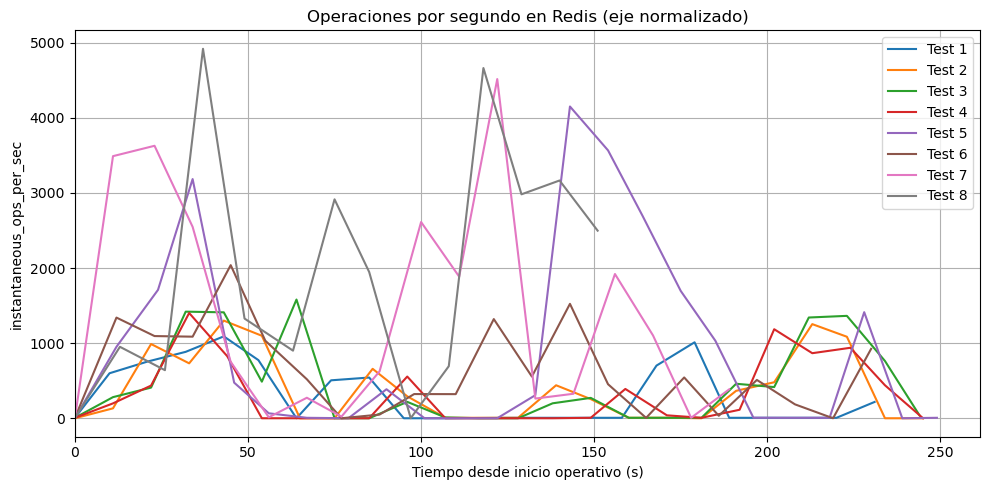

In [6]:
# Agrupar la información y presentarla gráficamente
# Se realiza un escalado de las muestras adapatada al tiempo de test, según TEST.sh es de 300 segundos
plt.figure(figsize=(10, 5))
for test_id, (tiempos, valores) in resultados.items():
    test_num = int(re.search(r'caso(\d+)', test_id).group(1))
    plt.plot(tiempos, valores, label=f"Test {test_num}")
plt.title("Operaciones por segundo en Redis (eje normalizado)")
plt.xlabel("Tiempo desde inicio operativo (s)")
plt.ylabel("instantaneous_ops_per_sec")
plt.legend()
plt.grid(True)
plt.xlim(left=0)
plt.tight_layout()
plt.show()
